In [9]:
import state_space_sim
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from tqdm import trange, tqdm
import sys
import scipy.io as sio
import scipy.signal as signal

In [10]:
import h5py
with h5py.File('/home/nicolas/Documents/code/Battery_degradation/data/data_prbs_10hz_500000_20190207_013502.mat', 'r') as f:
    fs_orig = f['fs'][()][0].squeeze().item()
    i_orig = f['I'][()].squeeze()
    u_orig = f['U1'][()].squeeze()


# Decimate the signal
Since the signal is sampled with 50kHz, we can safely decimate it down to 2kHz or even lower.
In the case below it is decimated down to 2kHz.

In [11]:
dec_factor = 250
fs = fs_orig/dec_factor

i = signal.decimate(i_orig,dec_factor,ftype='fir',n=20)[10:-10]
u = signal.decimate(u_orig,dec_factor,ftype='fir',n=20)[10:-10]

In [12]:
icorr = i*(-1) * 50/.625
fs

2000.0

(0.0, 1000.0)

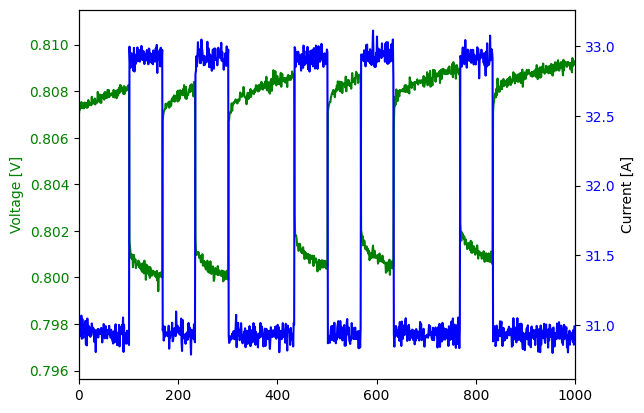

In [13]:
# Create the first axes object
fig, ax1 = plt.subplots()
ax1.plot(u, 'g-')
ax1.set_ylabel('Voltage [V]', color='g')
ax1.tick_params(axis='y', labelcolor='g')


# Create the second axes object, sharing the x-axis
ax2 = ax1.twinx()
ax2.plot(np.abs(icorr),color='b')
ax2.set_ylabel('Current [A]')
ax2.tick_params(axis='y', labelcolor='b')
ax1.set_xlim(0,1000)

# Parameter values
I took these values from [our paper](https://www.sciencedirect.com/science/article/pii/S0378775321000409), Figure 5.

In [14]:
Rs = jnp.array(.25/80)
R = jnp.array([.05, .3, 1.])/80
C = jnp.array([20., 50., 1000.])
alfa = jnp.array([.75, .99, .99])

In [15]:
def sim_z(Rs, R, C, alfa,fs, I, init):
    A, bl, m, d, T_end = state_space_sim.jgen(Rs,R,C,alfa,fs,len(I))
    mask = state_space_sim.generate_mask(A.shape)
    x_init = np.zeros(A.shape)
    x_init[0,:] = init
    return state_space_sim.forward_sim(A, bl, m, d, jnp.array(x_init), I, mask)

Parameter ```el``` is the number of samples to use. You can use even lower number for faster simulation.
The actual duration is ```el/fs``` in seconds.

In [16]:
el = 2000
y = sim_z(Rs, R, C, alfa,  fs, jnp.array(icorr[:el])-np.mean(icorr[:el]), init=0.)

(0.0, 2000.0)

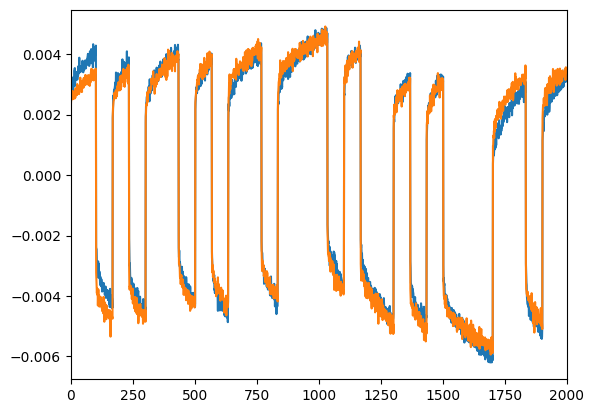

In [17]:
plt.plot(y)
plt.plot(u[:el]-np.mean(u[:el]))
plt.xlim(0,el)

# Optimisation

In [18]:
import optax
import jax
from jax import jit

In [19]:
def sim_z(Rs, R, Q, alfa,I):
    A, bl, m, d, T_end = state_space_sim.jgen(Rs,R,jnp.exp(Q),alfa,fs,len(I))
    mask = state_space_sim.generate_mask(A.shape)
    x_init = np.zeros(A.shape)
    return state_space_sim.forward_sim(A, bl, m, d, jnp.array(x_init), I, mask)


def compute_loss(params, y, U):
    y_pred = sim_z(I=y, **params)
    loss = jnp.sum(optax.squared_error(y_pred, U))
    return loss

# Apply JIT to both
jit_compute_loss = jit(compute_loss)
jit_loss_and_grad = jit(jax.value_and_grad(compute_loss))
# def sim(params):
#     A, bl, m, d, T_end = state_space_sim.jgen(params['Rs'],params['R'],params['Q'],params['alfa'],fs,len(U))
#     x_init = jnp.zeros(A.shape)
#     return state_space_sim.forward_sim(A, bl, m, d, x_init, current, mask)

In [20]:
params = {'R': jnp.array([3e-3, 5e-3, 1e-2]), 'Rs':jnp.array(3e-3), 'alfa':jnp.array([.75, .75, .75]), 'Q':jnp.log(jnp.array([10., 100., 1000.]))}

Q_optim = optax.adam(learning_rate = 1e-2)
other = optax.adam(learning_rate = 1e-4)

def create_mask(param_name):
  return {x: x in param_name for x in params.keys()}

def inv_mask(mask):
  return {k: not v for k,v in mask.items()}

Q_mask = create_mask(["Q", 'alfa'])

other_mask = inv_mask(Q_mask)

optimizer = optax.chain(
    # optax.clip_by_global_norm(1.0),  # Clip gradients to have a global norm of 1
    # optax.adam(learning_rate=1e-4)
    optax.masked(Q_optim, Q_mask),
    optax.masked(other, other_mask)
)

# Initialize parameters of the model + optimizer.

# Rs = jnp.array(.004)
# R = jnp.array([.1e-2, 3e-3])

# params = {'R': jnp.array([0.05, 0.3,0.8])/80., 'Rs':jnp.array(.24)/80., 'alfa':jnp.array([.67,.9, .9]), 'Q':jnp.log(jnp.array([30., 50., 700.]))}
opt_state = optimizer.init(params)

In [21]:
params

{'R': Array([0.003, 0.005, 0.01 ], dtype=float32),
 'Rs': Array(0.003, dtype=float32, weak_type=True),
 'alfa': Array([0.75, 0.75, 0.75], dtype=float32),
 'Q': Array([2.3025851, 4.6051702, 6.9077554], dtype=float32)}

(0.0, 2000.0)

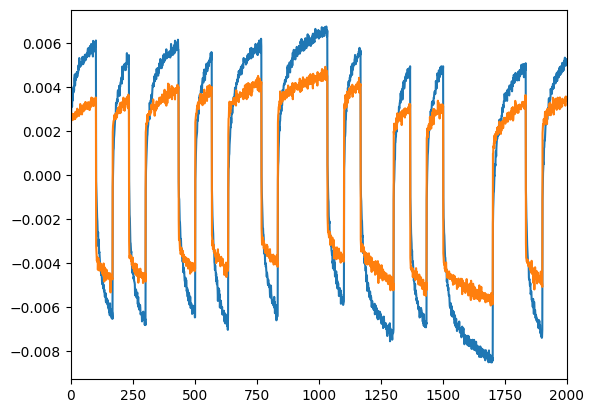

In [22]:
el = 2000
I = jnp.array(icorr[:el])-np.mean(icorr[:el])
U = jnp.array(u[:el]-np.mean(u[:el]))
y_sim = sim_z(I=I, **params)

plt.plot(y_sim)
plt.plot(u[:el]-np.mean(u[:el]))
plt.xlim(0,el)
# plt.plot(U)

In [23]:
# loss_and_grad = jax.value_and_grad(compute_loss)
losses = []
aps = []
pbar = trange(1000)

for _ in pbar:
    # grads = jax.grad(compute_loss)(params, yk_lim)
    loss_value, grads = jit_loss_and_grad(params, I, U)
    pbar.set_description(f"loss{loss_value.item()}")
    losses.append(loss_value.item())
    if jnp.isnan(loss_value):
        print('stop')
        break
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    # break
    aps.append(params['alfa'].tolist())
    params['alfa'] = jnp.clip(params['alfa'], a_min=0.6, a_max=1.)
    params['R'] = jnp.clip(params['R'], a_min=1e-5, a_max=100.)
    params['Rs'] = jnp.clip(params['Rs'], a_min=1e-5, a_max=100.)
    # break

loss0.00022828095825389028: 100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


In [24]:
params

{'Q': Array([2.3677835, 4.311728 , 6.656299 ], dtype=float32),
 'R': Array([0.00060442, 0.0024287 , 0.01230427], dtype=float32),
 'Rs': Array(0.00310791, dtype=float32),
 'alfa': Array([0.7244159 , 0.8981919 , 0.77499896], dtype=float32)}

In [25]:
Rs = jnp.array(.25/80)
R = jnp.array([.05, .3, 1.])/80
C = jnp.array([20., 50., 1000.])
alfa = jnp.array([.75, .99, .99])
R, Rs, jnp.log(C)

(Array([0.000625, 0.00375 , 0.0125  ], dtype=float32),
 Array(0.003125, dtype=float32, weak_type=True),
 Array([2.9957323, 3.912023 , 6.9077554], dtype=float32))

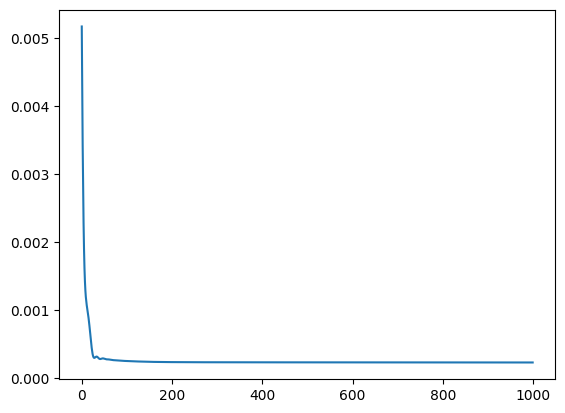

In [26]:
plt.plot(losses)

(0.0, 2000.0)

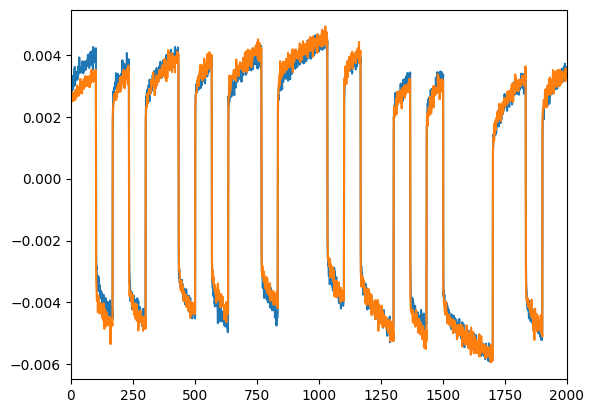

In [27]:
y_sim = sim_z(I=I, **params)

plt.plot(y_sim)
plt.plot(U)
plt.xlim(0,el)
# plt.plot(U)

In [28]:
loss = jnp.sum(optax.squared_error(y_sim, U))
loss

Array(0.00022828, dtype=float32)

In [29]:
jit_compute_loss(params, U)

TypeError: compute_loss() missing 1 required positional argument: 'U'

0.0015941022


(0.0, 2000.0)

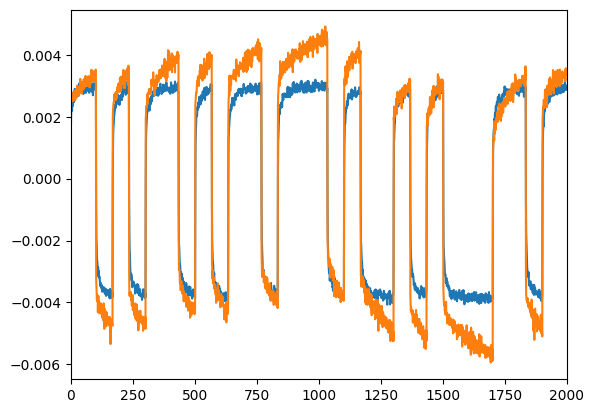

In [31]:
Rs=jnp.array(0.0018536,)
R=jnp.array([0.00165743, 0.0020229 , 0.02628605])
alpha = jnp.array([0.6339648, 0.7868509, 0.878289 ])
C = jnp.array([  2.6004696,  80.62754  , 526.90906] )


y_sim = sim_z(Rs,R,C,alpha,I)

loss = jnp.sum(optax.squared_error(y_sim, U))
print(loss)

plt.plot(y_sim)
plt.plot(U)
plt.xlim(0,el)
# plt.plot(U)